<a href="https://colab.research.google.com/github/rjribeiro/cell-datasets/blob/master/playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/rjribeiro/cell-datasets.git

Cloning into 'cell-datasets'...
remote: Enumerating objects: 1642, done.
remote: Counting objects: 100% (1642/1642), done.
remote: Compressing objects: 100% (1639/1639), done.
remote: Total 34056 (delta 17), reused 1627 (delta 3), pack-reused 32414
Receiving objects: 100% (34056/34056), 1.16 GiB | 36.35 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Checking out files: 100% (18050/18050), done.


In [2]:
%cd cell-datasets/
!ls

/content/cell-datasets
clustering.ipynb	       equalizacao_histograma.ipynb  playground.ipynb
data_augmentation.ipynb        model.h5			     README.md
data_preprocessing_test.ipynb  model.ipynb		     test.ipynb
dataset			       model.json
environment.yml		       organizacao_dataset.ipynb


In [ ]:
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Sequential, optimizers, preprocessing, initializers
from tensorflow.keras.layers import MaxPooling2D, Dense, BatchNormalization, Dropout, Flatten, InputLayer, Conv2D, Activation
import tensorflow as tf
from tensorflow.python.keras import backend as K
from sklearn import preprocessing, model_selection, metrics
from math import ceil
import pandas as pd
import numpy as np
from skimage import io
import seaborn as sns
from matplotlib import pyplot as plt

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

GPU is available


In [ ]:
class BatchGenerator(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([preprocessing.StandardScaler().fit_transform(io.imread(os.path.join(PATH, file_name))).reshape(
            (400, 400, 1))
                         for file_name in batch_x]), np.array(batch_y)



In [ ]:
class Model:
    def __init__(self, filters, learning_rate, dropout0, dropout1, activation, batch_size):
        self.filters = filters
        self.learning_rate = learning_rate
        self.dropout0 = dropout0
        self.dropout1 = dropout1
        self.activation = activation
        self.batch_size = batch_size
        self.model = self.create_model(filters, learning_rate, dropout0, dropout1, activation)
        self.history = None
        
    def create_model(self, filters, learning_rate, dropout0, dropout1, activation):
        model = Sequential()
        model.add(Conv2D(filters[0], kernel_size=(5, 5), input_shape=(400, 400, 1),
                         kernel_initializer=initializers.GlorotNormal(), padding="same"))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(BatchNormalization())
        model.add(Activation(activation))

        for index, filter_ in enumerate(filters[1:-2]):
            model.add(Conv2D(filter_, kernel_size=(3, 3), activation=activation, padding="same"))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(BatchNormalization())
            model.add(Activation(activation))

        model.add(Flatten())
        model.add(Dense(filters[-2]))
        model.add(BatchNormalization())
        model.add(Activation(activation))
        model.add(Dropout(dropout0))

        model.add(Dense(filters[-1]))
        model.add(BatchNormalization())
        model.add(Activation(activation))
        model.add(Dropout(dropout1))

        model.add(Dense(4, activation='softmax'))

        opt = optimizers.Adam(learning_rate)
        model.compile(loss='categorical_crossentropy', optimizer=opt,
                      metrics=['categorical_accuracy'])

        return model
    
    
    def fit(self, x_train, y_train, x_test, y_test, batch_size=32, epochs=12):
        train_batch_generator = BatchGenerator(x_train, y_train, batch_size=batch_size)
        test_batch_generator = BatchGenerator(x_test, y_test, batch_size=batch_size)
        self.history = self.model.fit(x=train_batch_generator, verbose=1, epochs=epochs, validation_data=test_batch_generator)

    def score(self, x, y, batch_size=32):
        batch_generator = BatchGenerator(x, y, batch_size=32)
        predict_labels = np.argmax(self.model.predict(batch_generator), axis=1)
        accuracy = metrics.accuracy_score(np.argmax(y_test, axis=1), predict_labels)
        return accuracy

    def get_confustion_matrix(self, x, y, batch_size=32):
        batch_generator = BatchGenerator(x, y, batch_size=batch_size)
        predict_labels = np.argmax(self.model.predict(batch_generator), axis=1)
        data = metrics.confusion_matrix(np.argmax(y_test, axis=1), predict_labels)
        confusion_matrix = pd.DataFrame(data=data, columns=['DIESTRO', 'ESTRO', 'METAESTRO', 'PROESTRO'], 
                                                   index= ['DIESTRO', 'ESTRO', 'METAESTRO', 'PROESTRO'])  
        return confusion_matrix
    
    def plot_train_metrics(self):
        sns.set(rc={'figure.figsize':(14,5)})
        sns.set_style("whitegrid")
        sns.lineplot(data=pd.DataFrame(self.model.history.history), palette="tab10")
        plt.xlabel("Epochs");
        

In [ ]:
PATH = os.path.join("dataset", "data_augmented")
df = pd.read_csv(os.path.join("dataset", "name_data_augmented.csv"), index_col=0)
X = df.filename.values
Y = df.label.values

In [ ]:
sss = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.1)
batch_size = 32
metrics_list = []
for train_index, test_index in sss.split(X, Y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = pd.get_dummies(Y[train_index]).values, pd.get_dummies(Y[test_index]).values
    model = Model(filters=[16, 32, 128, 128, 32, 8], learning_rate=0.0005, 
                  activation="relu", dropout0=0.5, dropout1=0.3, batch_size=batch_size)
    model.fit(x_train, y_train, x_test, y_test, epochs=12)

Train for 449 steps, validate for 50 steps
Epoch 1/12
449/449 [==============================] - 141s 314ms/step - loss: 0.9933 - categorical_accuracy: 0.6248 - val_loss: 0.7180 - val_categorical_accuracy: 0.8513
Epoch 2/12
449/449 [==============================] - 142s 317ms/step - loss: 0.6246 - categorical_accuracy: 0.8224 - val_loss: 0.3289 - val_categorical_accuracy: 0.9329
Epoch 3/12
449/449 [==============================] - 147s 327ms/step - loss: 0.4552 - categorical_accuracy: 0.8647 - val_loss: 0.7866 - val_categorical_accuracy: 0.7208
Epoch 4/12
449/449 [==============================] - 142s 317ms/step - loss: 0.3669 - categorical_accuracy: 0.8873 - val_loss: 0.1818 - val_categorical_accuracy: 0.9417
Epoch 5/12
449/449 [==============================] - 143s 319ms/step - loss: 0.3026 - categorical_accuracy: 0.9100 - val_loss: 0.2130 - val_categorical_accuracy: 0.9398
Epoch 6/12
449/449 [==============================] - 142s 316ms/step - loss: 0.2877 - categorical_accuracy

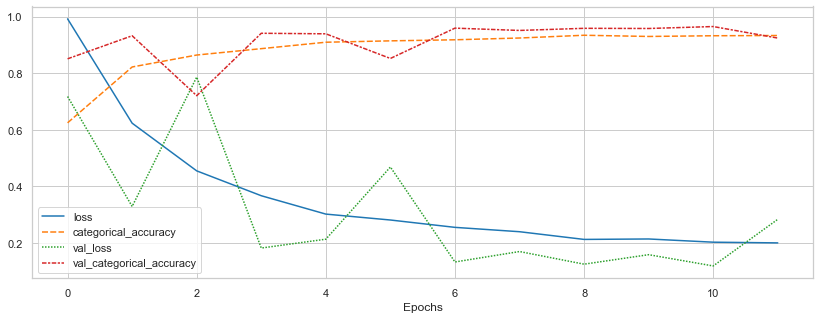

In [ ]:
model.plot_train_metrics()

In [ ]:
model.get_confustion_matrix(x_test, y_test)

,DIESTRO,ESTRO,METAESTRO,PROESTRO
DIESTRO,389,0,8,0
ESTRO,0,400,0,0
METAESTRO,20,3,374,0
PROESTRO,1,6,82,311


In [ ]:
model.score(x_test, y_test)

0.9247176913425345